In [1]:
import configparser
import math

import numpy as np
import pandas
import plotly
import plotly.graph_objs as go
from plotnine import *
import psycopg2
import sklearn.manifold
import umap

In [2]:
# Ensure TSNE always returns the same results
np.random.seed(42)

parser = configparser.ConfigParser()
parser.read('../database.ini')

db_password = parser['psql']['password']
epilepsy_id = 'DOID:1826'

supervised_predictions_df = pandas.read_csv('https://raw.githubusercontent.com/dhimmel/learn/b2460a1ecdec1078d673634688784f3eb5e3fc43/prediction/predictions/probabilities.tsv', sep='\t')

In [3]:
def construct_disease_query(disease_id):
    # If this query is used for different node types, it may be necessary to add an additional condition
    # that the matching node is of the correct type e.g. Disease
    query = f'''
            SELECT path_count, p_value, metapath_id, source_node.name AS source_name, 
                   target_node.name AS target_name, source_node.identifier AS source_identifier 
            FROM dj_hetmech_app_pathcount pc 
            JOIN dj_hetmech_app_node source_node 
               ON pc.source_id = source_node.id 
            JOIN dj_hetmech_app_node target_node 
               ON pc.target_id = target_node.id     
            WHERE target_node.identifier='{disease_id}' OR source_node.identifier='{disease_id}'
            ORDER BY pc.p_value
            '''
    return query

In [4]:
def get_disease_df(disease_id, db_password, supervised_predictions_df):
    query = construct_disease_query(disease_id)
    connection = psycopg2.connect(host = 'hetmech-db-dev.cobepk65dd7j.us-east-1.rds.amazonaws.com', 
                                  database = 'dj_hetmech', user = 'read_only_user', password = db_password)

    # Get the unsupervised compound information for a given disease
    metapaths = pandas.read_sql(query, connection)

    # If the source node is a disease instead of a compound, swap it with the target node
    reversed_indices = metapaths['source_identifier'] == disease_id
    metapaths['temp'] = metapaths['source_name']
    metapaths.loc[reversed_indices, 'source_name'] = metapaths['target_name']
    metapaths.loc[reversed_indices, 'target_name'] = metapaths['temp']

    metapaths = metapaths.drop(['temp', 'source_identifier'], axis=1)
    
    metapaths = metapaths.sort_values(by=['source_name', 'metapath_id'])
    # Ensure that you only have one copy of each (source_name, metapath_id) pair
    metapaths = metapaths.drop_duplicates(subset=['source_name', 'metapath_id'])
    # Remove any rows with NaN values
    metapaths = metapaths.dropna()
    min_p_value = metapaths[metapaths.p_value != 0].p_value.min()
    # Replace zero p-values to keep the log conversion from breaking
    metapaths.loc[metapaths.p_value == 0, 'p_value'] = min_p_value
    metapaths['neg_log_p_value'] = metapaths.p_value.apply(lambda x: -math.log10(x))

    max_column = metapaths.groupby('source_name')['neg_log_p_value'].max()
    mean_column = metapaths.groupby('source_name')['neg_log_p_value'].mean()

    neg_log_sum = metapaths.groupby('source_name').sum()
    neg_log_sum = neg_log_sum.sort_values(by='neg_log_p_value', ascending=False)

    neg_log_sum['max_neg_log'] = max_column
    neg_log_sum['mean_neg_log'] = mean_column
    neg_log_sum['max_percent_of_total'] = 100 * (neg_log_sum['max_neg_log'] / neg_log_sum['neg_log_p_value'])

    disease_predictions_df = supervised_predictions_df[supervised_predictions_df.disease_id == disease_id]
    # Remove predictions on drugs not in the other dataframe
    disease_predictions_df = disease_predictions_df[disease_predictions_df.compound_name.isin(neg_log_sum.index)]
    disease_predictions_df = disease_predictions_df.sort_values(by='disease_percentile', ascending=False)

    # Get the unsupervised compound ranking
    neg_log_sum = neg_log_sum.reset_index()
    neg_log_sum['unsupervised_rank'] = neg_log_sum.index

    # Sort neg_log_sum matching names in disease_predicitons_df 
    combined_df = neg_log_sum.merge(disease_predictions_df, how="left", right_on='compound_name', left_on='source_name')

    combined_df = combined_df.sort_values(by='disease_percentile', ascending=False).reset_index(drop=True)
    combined_df['supervised_rank'] = combined_df.index.copy()

    return metapaths, combined_df

In [5]:
metapath_df, sum_df = get_disease_df(epilepsy_id, db_password, supervised_predictions_df)
columns_to_drop = ['path_count',
                   'p_value',
                   'max_neg_log',
                   'mean_neg_log',
                   'max_percent_of_total',
                   'n_trials',
                   'status_drugcentral',
                   'training_prediction',
                   'category',
                   'compound_name',
                   'disease_percentile',
                   'compound_percentile',
                   'prior_prob',
                   'prediction',
                   'disease_name'
                  ]
sum_df = sum_df.drop(columns_to_drop, axis=1)
sum_df.rename(columns = {'neg_log_p_value': 'compound_sum_neg_log_p_value'}, inplace=True)

sum_df['divergence'] = sum_df['supervised_rank'] - sum_df['unsupervised_rank']

sum_df.head()

source_name  compound_sum_neg_log_p_value  unsupervised_rank compound_id  \
0  Topiramate                     43.735595                  0     DB00273   
1    Ethotoin                     34.047045                 12     DB00754   
2    Quazepam                     24.477587                 65     DB01589   
3  Alprazolam                     33.511351                 15     DB00404   
4   Primidone                     33.931793                 13     DB00794   

  disease_id  status  status_trials  supervised_rank  divergence  
0  DOID:1826       1            NaN                0           0  
1  DOID:1826       0            0.0                1         -11  
2  DOID:1826       0            0.0                2         -63  
3  DOID:1826       0            1.0                3         -12  
4  DOID:1826       1            NaN                4          -9

In [6]:
combined_df = metapath_df.merge(sum_df)
combined_df = combined_df.sort_values(by='divergence')

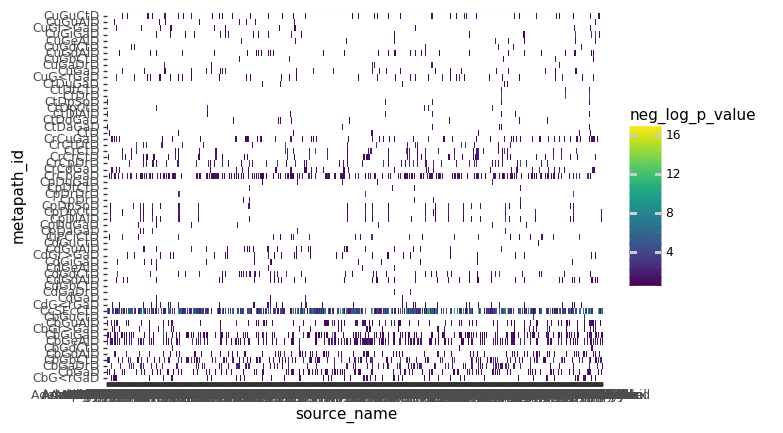

<ggplot: (-9223363256732627561)>

In [7]:
(ggplot(combined_df, aes('source_name', 'metapath_id', fill='neg_log_p_value'))
 + geom_tile()
)

In [8]:
pivot_df = combined_df.pivot('source_name', 'metapath_id', 'neg_log_p_value')
pivot_df = pivot_df.fillna(0)
# Drop compound treats disease edge to prevent information leaks
pivot_df = pivot_df.drop('CtD', axis=1)
pivot_df.head()

metapath_id  CbG<rGaD     CbGaD  CbGaDrD   CbGbCtD   CbGdAlD  CbGdCtD  \
source_name                                                             
Abacavir     0.000000  1.968488      0.0  0.000000  2.186818      0.0   
Abiraterone  0.000000  0.000000      0.0  0.000000  1.294707      0.0   
Acamprosate  0.000000  1.740126      0.0  3.934527  0.000000      0.0   
Acarbose     1.099501  0.000000      0.0  0.000000  1.101204      0.0   
Acebutolol   0.000000  0.000000      0.0  0.000000  0.000000      0.0   

metapath_id   CbGeAlD   CbGiGaD  CbGr>GaD   CbGuAlD   ...     CuGaD  CuGaDrD  \
source_name                                           ...                      
Abacavir     0.000000  0.000000       0.0  0.000000   ...       0.0      0.0   
Abiraterone  0.000000  0.000000       0.0  0.000000   ...       0.0      0.0   
Acamprosate  3.199415  2.102324       0.0  1.823625   ...       0.0      0.0   
Acarbose     3.650422  0.000000       0.0  0.000000   ...       0.0      0.0   
Acebutolol   0.000000  0.000000       0.0  0.000000   ...       0.0      0.0   

metapath_id  CuGbCtD  CuGdAlD  CuGdCtD  CuGeAlD  CuGiGaD  CuGr>GaD  CuGuAlD  \
source_name                                                                   
Abacavir         0.0      0.0      0.0      0.0      0.0       0.0      0.0   
Abiraterone      0.0      0.0      0.0      0.0      0.0       0.0      0.0   
Acamprosate      0.0      0.0      0.0      0.0      0.0       0.0      0.0   
Acarbose         0.0      0.0      0.0      0.0      0.0       0.0      0.0   
Acebutolol       0.0      0.0      0.0      0.0      0.0       0.0      0.0   

metapath_id  CuGuCtD  
source_name           
Abacavir         0.0  
Abiraterone      0.0  
Acamprosate      0.0  
Acarbose         0.0  
Acebutolol       0.0  

[5 rows x 59 columns]

In [9]:
embedded_data = sklearn.manifold.TSNE().fit_transform(pivot_df)

In [10]:
sum_df = sum_df.sort_values(by='source_name')

In [11]:
tsne_df = pandas.DataFrame({'axis1': embedded_data[:,0], 'axis2': embedded_data[:,1], 
                            'status': sum_df['status'], 'divergence': sum_df['divergence'],
                            'neg_log_p_value': sum_df['compound_sum_neg_log_p_value'], 
                            'source_name': pivot_df.index})
tsne_df = tsne_df.merge(pivot_df, left_on='source_name', right_index=True)
tsne_df.head()

axis1      axis2  status  divergence  neg_log_p_value  source_name  \
760    8.556794   5.399414       0          -5         7.736997     Abacavir   
463   -4.927469   1.732467       0        -753         3.644410  Abiraterone   
100  -53.858093 -12.120009       0          50        26.122359  Acamprosate   
1175  37.713909  14.517929       0         528         8.953199     Acarbose   
939  -14.735936  -4.953999       0          -7         6.058565   Acebutolol   

      CbG<rGaD     CbGaD  CbGaDrD   CbGbCtD   ...     CuGaD  CuGaDrD  CuGbCtD  \
760   0.000000  1.968488      0.0  0.000000   ...       0.0      0.0      0.0   
463   0.000000  0.000000      0.0  0.000000   ...       0.0      0.0      0.0   
100   0.000000  1.740126      0.0  3.934527   ...       0.0      0.0      0.0   
1175  1.099501  0.000000      0.0  0.000000   ...       0.0      0.0      0.0   
939   0.000000  0.000000      0.0  0.000000   ...       0.0      0.0      0.0   

      CuGdAlD  CuGdCtD  CuGeAlD  CuGiGaD  CuGr>GaD  CuGuAlD  CuGuCtD  
760       0.0      0.0      0.0      0.0       0.0      0.0      0.0  
463       0.0      0.0      0.0      0.0       0.0      0.0      0.0  
100       0.0      0.0      0.0      0.0       0.0      0.0      0.0  
1175      0.0      0.0      0.0      0.0       0.0      0.0      0.0  
939       0.0      0.0      0.0      0.0       0.0      0.0      0.0  

[5 rows x 65 columns]

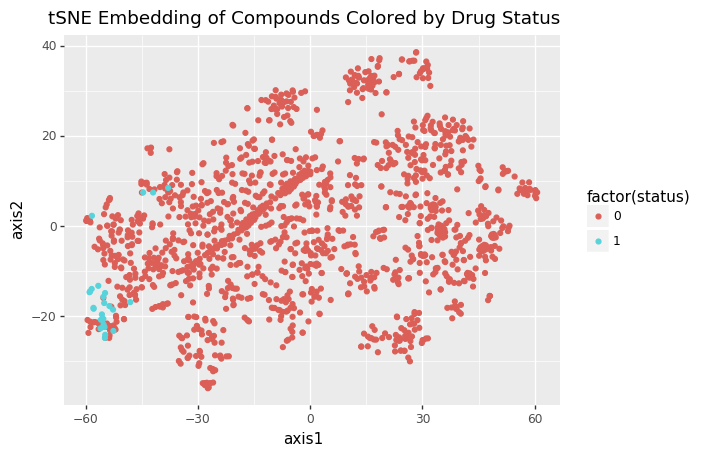

<ggplot: (-9223363256732093012)>

In [12]:
ggplot(tsne_df, aes('axis1', 'axis2', color='factor(status)')) + geom_point() + ggtitle('tSNE Embedding of Compounds Colored by Drug Status')

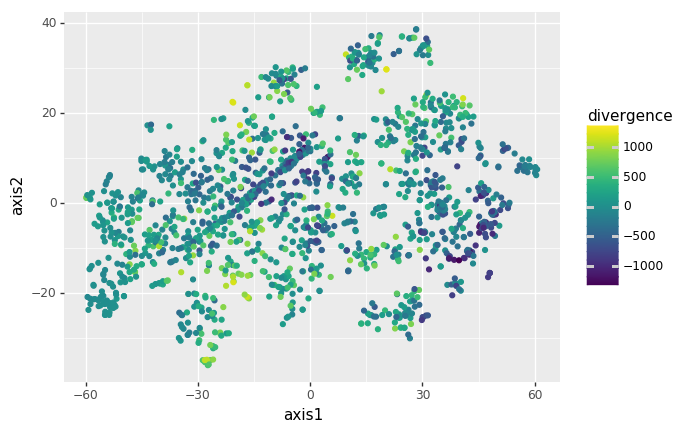

<ggplot: (-9223363256732121477)>

In [13]:
ggplot(tsne_df, aes('axis1', 'axis2', color='divergence')) + geom_point() 

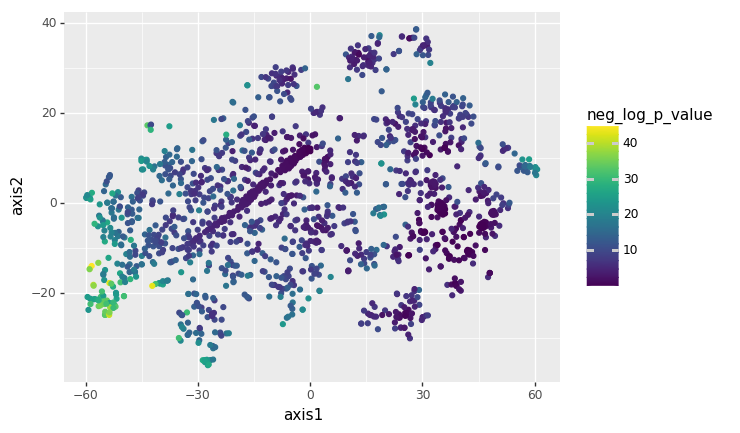

<ggplot: (8780116956543)>

In [14]:
ggplot(tsne_df, aes('axis1', 'axis2', color='neg_log_p_value')) + geom_point() 

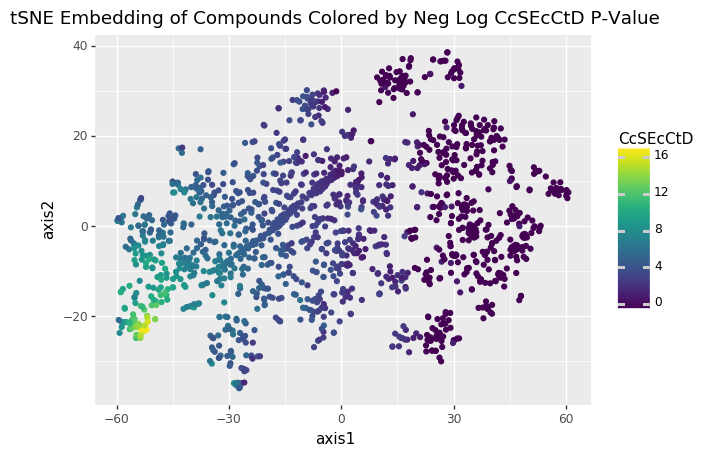

<ggplot: (8780117002297)>

In [15]:
ggplot(tsne_df, aes('axis1', 'axis2', color='CcSEcCtD')) + geom_point() + ggtitle('tSNE Embedding of Compounds Colored by Neg Log CcSEcCtD P-Value')

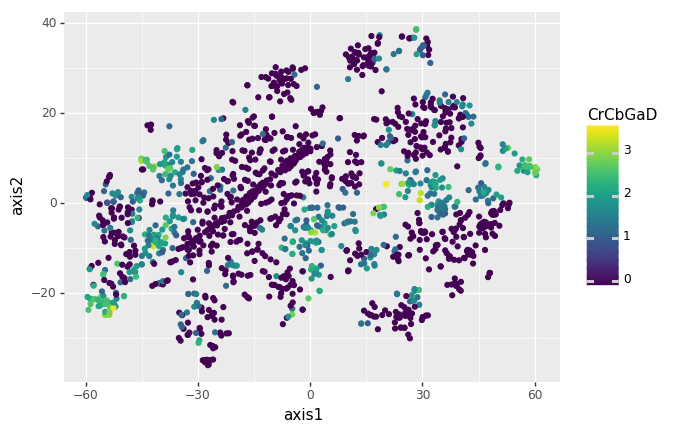

<ggplot: (8780115380172)>

In [16]:
ggplot(tsne_df, aes('axis1', 'axis2', color='CrCbGaD')) + geom_point() 

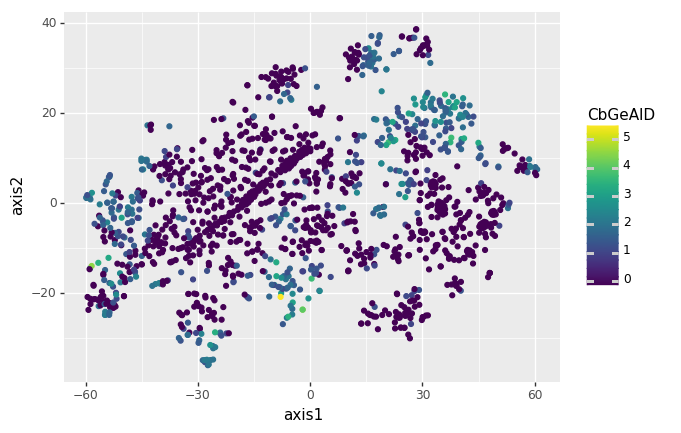

<ggplot: (-9223363256739408117)>

In [17]:
ggplot(tsne_df, aes('axis1', 'axis2', color='CbGeAlD')) + geom_point() 

In [18]:
embedded_data = umap.UMAP().fit_transform(pivot_df)

In [19]:
umap_df = pandas.DataFrame({'axis1': embedded_data[:,0], 'axis2': embedded_data[:,1], 
                            'status': sum_df['status'], 'divergence': sum_df['divergence'],
                            'neg_log_p_value': sum_df['compound_sum_neg_log_p_value'], 
                            'source_name': pivot_df.index, 'trials': sum_df['status_trials']})
umap_df = umap_df.merge(pivot_df, left_on='source_name', right_index=True)
umap_df.head()

axis1     axis2  status  divergence  neg_log_p_value  source_name  \
760  -1.457687  5.556216       0          -5         7.736997     Abacavir   
463  -1.330380  5.588799       0        -753         3.644410  Abiraterone   
100   3.622695  5.168979       0          50        26.122359  Acamprosate   
1175 -4.230705  3.208268       0         528         8.953199     Acarbose   
939   0.088489  1.801574       0          -7         6.058565   Acebutolol   

      trials  CbG<rGaD     CbGaD  CbGaDrD   ...     CuGaD  CuGaDrD  CuGbCtD  \
760      0.0  0.000000  1.968488      0.0   ...       0.0      0.0      0.0   
463      0.0  0.000000  0.000000      0.0   ...       0.0      0.0      0.0   
100      0.0  0.000000  1.740126      0.0   ...       0.0      0.0      0.0   
1175     0.0  1.099501  0.000000      0.0   ...       0.0      0.0      0.0   
939      0.0  0.000000  0.000000      0.0   ...       0.0      0.0      0.0   

      CuGdAlD  CuGdCtD  CuGeAlD  CuGiGaD  CuGr>GaD  CuGuAlD  CuGuCtD  
760       0.0      0.0      0.0      0.0       0.0      0.0      0.0  
463       0.0      0.0      0.0      0.0       0.0      0.0      0.0  
100       0.0      0.0      0.0      0.0       0.0      0.0      0.0  
1175      0.0      0.0      0.0      0.0       0.0      0.0      0.0  
939       0.0      0.0      0.0      0.0       0.0      0.0      0.0  

[5 rows x 66 columns]

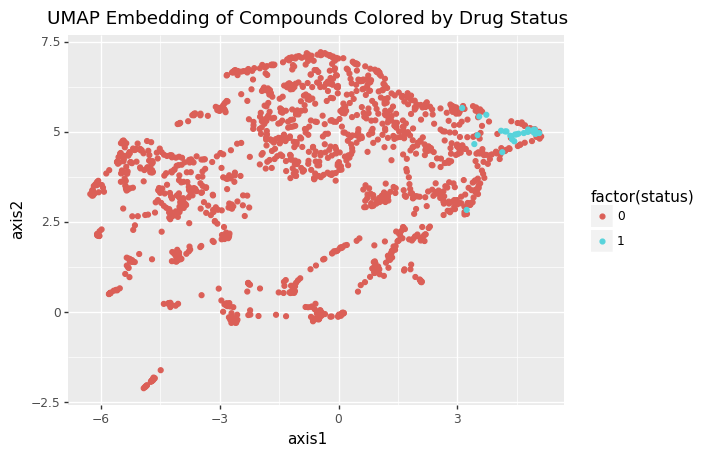

<ggplot: (8780116991636)>

In [20]:
ggplot(umap_df, aes('axis1', 'axis2', color='factor(status)')) + geom_point() + ggtitle('UMAP Embedding of Compounds Colored by Drug Status')

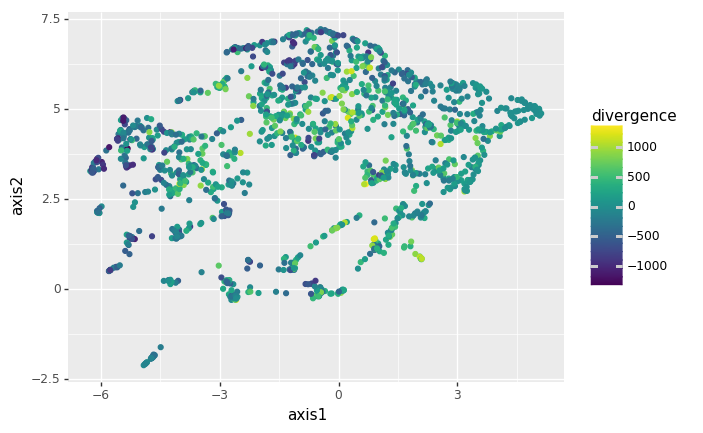

<ggplot: (8780122572187)>

In [21]:
ggplot(umap_df, aes('axis1', 'axis2', color='divergence')) + geom_point() 

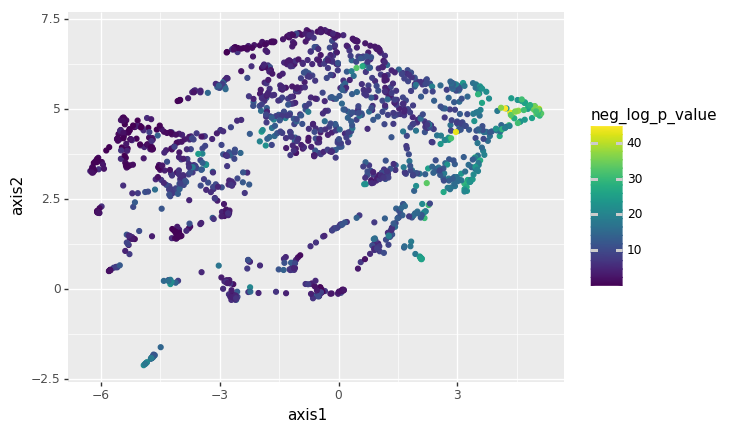

<ggplot: (-9223363256737726397)>

In [22]:
ggplot(umap_df, aes('axis1', 'axis2', color='neg_log_p_value')) + geom_point() 

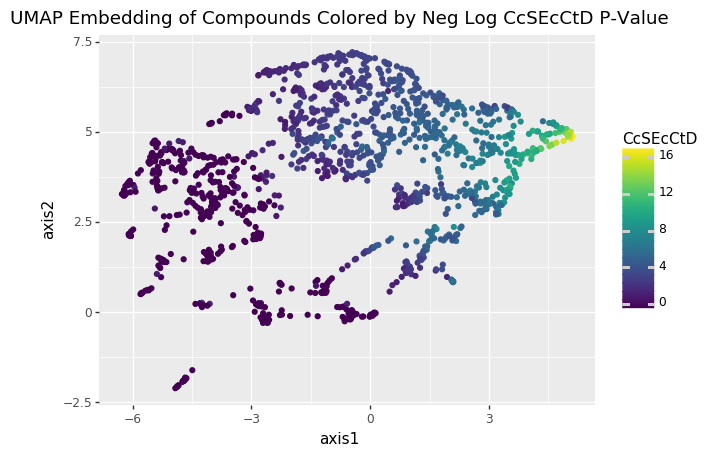

<ggplot: (-9223363256747300990)>

In [23]:
ggplot(umap_df, aes('axis1', 'axis2', color='CcSEcCtD')) + geom_point() + ggtitle('UMAP Embedding of Compounds Colored by Neg Log CcSEcCtD P-Value')

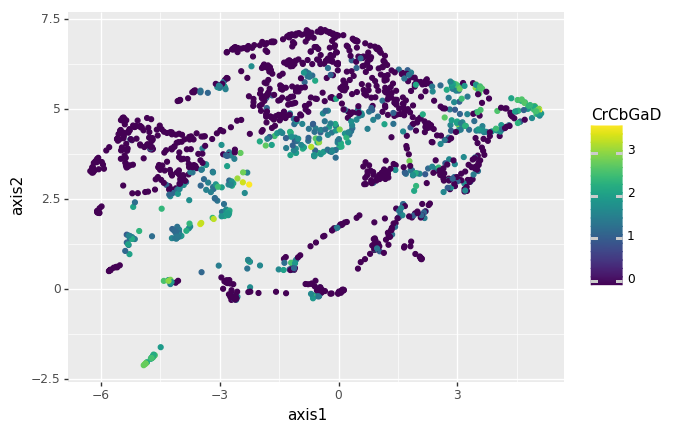

<ggplot: (-9223363256736961385)>

In [24]:
ggplot(umap_df, aes('axis1', 'axis2', color='CrCbGaD')) + geom_point() 

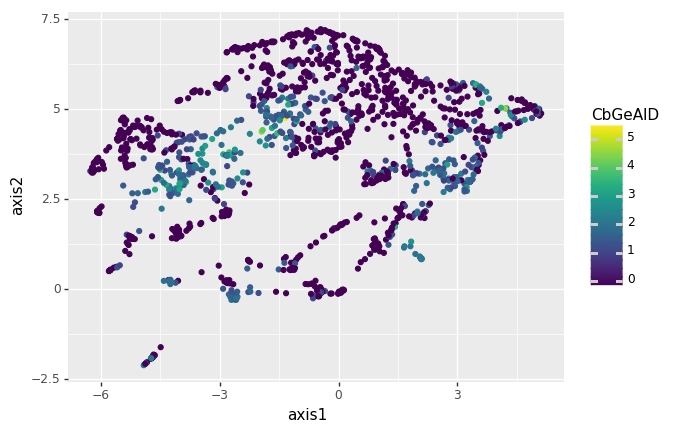

<ggplot: (8780112760566)>

In [25]:
ggplot(umap_df, aes('axis1', 'axis2', color='CbGeAlD')) + geom_point() 

In [26]:
compound_type_df = pandas.read_csv('https://raw.githubusercontent.com/dhimmel/drugbank/7b94454b14a2fa4bb9387cb3b4b9924619cfbd3e/data/drugbank-slim.tsv', sep='\t')
compound_type_df = compound_type_df.drop(['drugbank_id', 'type', 'groups', 'atc_codes', 'inchikey', 'inchi'], axis=1)
compound_type_df.head()

umap_df = umap_df.merge(compound_type_df, left_on='source_name', right_on='name', suffixes=[False, False])
umap_df = umap_df.drop(['name'], axis=1)

In [27]:
umap_df.head()

axis1     axis2  status  divergence  neg_log_p_value  source_name  \
0 -1.457687  5.556216       0          -5         7.736997     Abacavir   
1 -1.330380  5.588799       0        -753         3.644410  Abiraterone   
2  3.622695  5.168979       0          50        26.122359  Acamprosate   
3 -4.230705  3.208268       0         528         8.953199     Acarbose   
4  0.088489  1.801574       0          -7         6.058565   Acebutolol   

   trials  CbG<rGaD     CbGaD  CbGaDrD  \
0     0.0  0.000000  1.968488      0.0   
1     0.0  0.000000  0.000000      0.0   
2     0.0  0.000000  1.740126      0.0   
3     0.0  1.099501  0.000000      0.0   
4     0.0  0.000000  0.000000      0.0   

                         ...                          CuGbCtD  CuGdAlD  \
0                        ...                              0.0      0.0   
1                        ...                              0.0      0.0   
2                        ...                              0.0      0.0   
3                        ...                              0.0      0.0   
4                        ...                              0.0      0.0   

   CuGdCtD  CuGeAlD  CuGiGaD  CuGr>GaD  CuGuAlD  CuGuCtD  \
0      0.0      0.0      0.0       0.0      0.0      0.0   
1      0.0      0.0      0.0       0.0      0.0      0.0   
2      0.0      0.0      0.0       0.0      0.0      0.0   
3      0.0      0.0      0.0       0.0      0.0      0.0   
4      0.0      0.0      0.0       0.0      0.0      0.0   

                                          categories  \
0   Anti-HIV Agents|Reverse Transcriptase Inhibitors   
1                                                NaN   
2                                 Alcohol Deterrents   
3                                                NaN   
4  Antihypertensive Agents|Sympathomimetics|Adren...   

                                         description  
0  Abacavir (ABC) is a powerful nucleoside analog...  
1  Abiraterone is a derivative of steroidal proge...  
2  Acamprosate, also known by the brand name Camp...  
3  An inhibitor of alpha glucosidase that retards...  
4  A cardioselective beta-adrenergic antagonist w...  

[5 rows x 68 columns]

In [28]:
# Set up plotly
plotly.offline.init_notebook_mode(connected=True)

marker_info = {
    'size': 6,
    'color': umap_df.status,
    'showscale': True
}

plot_params = {
    'data': [go.Scatter(x=umap_df.axis1,
                        y=umap_df.axis2,
                        text=umap_df.source_name,
                        hoverinfo='text',
                        mode='markers', 
                        marker=marker_info)],
    'layout': {
        'hovermode': 'closest',
        'title': 'UMAP Embedding of Compounds by Drug Status',
        'xaxis': {
            'title': 'UMAP Axis 1'
        },
        'yaxis': {
            'title': 'UMAP Axis 2'
        }
        
    }
}

plotly.offline.iplot(plot_params)

In [29]:
marker_info = {
    'size': 6,
    'color': umap_df.trials,
    'showscale': True
}

plot_params = {
    'data': [go.Scatter(x=umap_df.axis1,
                        y=umap_df.axis2,
                        text=umap_df.source_name,
                        hoverinfo='text',
                        mode='markers', 
                        marker=marker_info)],
    'layout': {
        'hovermode': 'closest',
        'title': 'UMAP Embedding of Compounds Colored by Trials Info',
        'xaxis': {
            'title': 'UMAP Axis 1'
        },
        'yaxis': {
            'title': 'UMAP Axis 2'
        }
        
    }
}

plotly.offline.iplot(plot_params)

In [30]:
marker_info = {
    'size': 6,
    'color': umap_df.CcSEcCtD,
    'showscale': True
}

plot_params = {
    'data': [go.Scatter(x=umap_df.axis1,
                        y=umap_df.axis2,
                        text=umap_df.source_name,
                        hoverinfo='text',
                        mode='markers', 
                        marker=marker_info)],
    'layout': {
        'hovermode': 'closest',
        'title': 'UMAP Embedding of Compounds by CcSEcCtD Neg Log P-Value',
        'xaxis': {
            'title': 'UMAP Axis 1'
        },
        'yaxis': {
            'title': 'UMAP Axis 2'
        }
        
    }
}

plotly.offline.iplot(plot_params)

In [31]:
# Add info about whether drugs are ictogenic
ictogenic_df = pandas.read_csv('https://raw.githubusercontent.com/dhimmel/rephetio/127b094076684b40ea35f6e42aca8967afdb9f56/epilepsy/data/PK-curation.tsv', sep='\t')
ictogenic_df = ictogenic_df.drop(['prediction', 'disease_pctl', 'phcodb', 'comment', 'sources', 'trials'], axis=1)

In [32]:
ictogenic_df = ictogenic_df.merge(umap_df, left_on='name', right_on='source_name', how='right', suffixes=(False, False))
ictogenic_df.head()

name category     axis1     axis2  status  divergence  \
0  Topiramate     AIGD  4.207170  5.014900       1           0   
1    Ethotoin     AIGD  4.844005  5.040060       0         -11   
2    Quazepam     AIGD  4.362460  5.296840       0         -63   
3  Alprazolam     AIGD  4.998245  4.863200       0         -12   
4   Primidone     AIGD  4.974418  4.945452       1          -9   

   neg_log_p_value source_name  trials  CbG<rGaD  \
0        43.735595  Topiramate     NaN       0.0   
1        34.047045    Ethotoin     0.0       0.0   
2        24.477587    Quazepam     0.0       0.0   
3        33.511351  Alprazolam     1.0       0.0   
4        33.931793   Primidone     NaN       0.0   

                         ...                          CuGbCtD  CuGdAlD  \
0                        ...                              0.0      0.0   
1                        ...                              0.0      0.0   
2                        ...                              0.0      0.0   
3                        ...                              0.0      0.0   
4                        ...                              0.0      0.0   

   CuGdCtD  CuGeAlD  CuGiGaD  CuGr>GaD  CuGuAlD   CuGuCtD  \
0      0.0      0.0      0.0       0.0      0.0  0.000000   
1      0.0      0.0      0.0       0.0      0.0  0.000000   
2      0.0      0.0      0.0       0.0      0.0  0.000000   
3      0.0      0.0      0.0       0.0      0.0  1.598265   
4      0.0      0.0      0.0       0.0      0.0  0.000000   

                                          categories  \
0  Anticonvulsants|Anti-Obesity Agents|Neuroprote...   
1                                    Anticonvulsants   
2            Hypnotics and Sedatives|Benzodiazepines   
3  Anti-Anxiety Agents|Hypnotics and Sedatives|GA...   
4                       Anticonvulsants|Barbiturates   

                                         description  
0  Topiramate (brand name Topamax) is an anticonv...  
1  Ethotoin is a hydantoin derivative and anticon...  
2  Quazepam is a drug which is a benzodiazepine d...  
3  A triazolobenzodiazepine compound with antianx...  
4  An antiepileptic agent related to the barbitur...  

[5 rows x 70 columns]

In [33]:
marker_info = {
    'size': 6,
    #'color': ictogenic_df.category,
    #'showscale': True
}

categories = ictogenic_df['category'].unique()

In [34]:
traces = [go.Scatter(x=ictogenic_df[ictogenic_df['category'] == category].axis1,
                     y=ictogenic_df[ictogenic_df['category'] == category].axis2,
                     text=ictogenic_df.source_name,
                     name=category,
                     hoverinfo='text',
                     mode='markers', 
                     marker=marker_info) 
          for category in categories]

traces.append(go.Scatter(x=ictogenic_df[ictogenic_df['category'].isna()].axis1,
                         y=ictogenic_df[ictogenic_df['category'].isna()].axis2,
                         text=ictogenic_df.source_name,
                         name='NaN',
                         hoverinfo='text',
                         mode='markers', 
                         marker={'size': 6, 'color': 'lightgrey', 'opacity': .5}))

plot_params = {
    # We have to use a list comprehension over portions of the data because plotly doesn't like strings
    'data': traces,
    'layout': {
        'hovermode': 'closest',
        'title': 'UMAP Embedding of Top 100 Rephetio Componds Colored by Whether They Are Ictogenic',
        'xaxis': {
            'title': 'UMAP Axis 1'
        },
        'yaxis': {
            'title': 'UMAP Axis 2'
        }
        
    }
}

plotly.offline.iplot(plot_params)

In [35]:
compound_type_df = pandas.read_csv('https://raw.githubusercontent.com/dhimmel/rephetio/f02d44fde7eeef0ffdca0800e0b43c48d800c86d/epilepsy/data/compounds-categories.tsv', sep='\t')

compound_type_df.head()

category  count  \
0          Anticonvulsants     28   
1  Hypnotics and Sedatives     24   
2          GABA Modulators     17   
3          Benzodiazepines     15   
4      Anti-Anxiety Agents     12   

                                           compounds  
0  Acetazolamide, Carbamazepine, Clobazam, Clonaz...  
1  Alprazolam, Butabarbital, Butethal, Chlordiaze...  
2  Alprazolam, Bromazepam, Chlordiazepoxide, Clon...  
3  Alprazolam, Bromazepam, Chlordiazepoxide, Cino...  
4  Alprazolam, Bromazepam, Chlordiazepoxide, Diaz...

In [36]:
# Add columns to dataframe reflecting whether compounds are drugs of specific types
umap_df['anticonvulsant'] = 0

umap_df.loc[umap_df['categories'].str.contains('Anticonvulsant').fillna(False), 'anticonvulsant'] = 1

In [37]:
# Add columns to dataframe reflecting whether compounds are drugs of specific types
umap_df['Hypnotics and Sedatives'] = 0

umap_df.loc[umap_df['categories'].str.contains('Hypnotics and Sedatives').fillna(False), 'Hypnotics and Sedatives'] = 1

In [38]:
# Add columns to dataframe reflecting whether compounds are drugs of specific types
umap_df['GABA Modulators'] = 0

umap_df.loc[umap_df['categories'].str.contains('GABA Modulators').fillna(False), 'GABA Modulators'] = 1

In [39]:
# Add columns to dataframe reflecting whether compounds are drugs of specific types
umap_df['Benzodiazepines'] = 0

umap_df.loc[umap_df['categories'].str.contains('Benzodiazepines').fillna(False), 'Benzodiazepines'] = 1

In [40]:
# Add columns to dataframe reflecting whether compounds are drugs of specific types
umap_df['Anti-Anxiety Agents'] = 0

umap_df.loc[umap_df['categories'].str.contains('Anti-Anxiety Agents').fillna(False), 'Anti-Anxiety Agents'] = 1

In [41]:
marker_info = {
    'size': 6,
    'color': umap_df.anticonvulsant,
    'showscale': True
}
plot_params = {
    'data': [go.Scatter(x=umap_df.axis1,
                        y=umap_df.axis2,
                        text=umap_df.source_name,
                        hoverinfo='text',
                        mode='markers', 
                        marker=marker_info)],
    'layout': {
        'hovermode': 'closest',
        'title': 'UMAP Embedding of Compounds With Anticonvulsant Drugs Highlighted',
        'xaxis': {
            'title': 'UMAP Axis 1'
        },
        'yaxis': {
            'title': 'UMAP Axis 2'
        }
    }
}
plotly.offline.iplot(plot_params)

In [42]:
marker_info = {
    'size': 6,
    'color': umap_df['Hypnotics and Sedatives'],
    'showscale': True
}
plot_params = {
    'data': [go.Scatter(x=umap_df.axis1,
                        y=umap_df.axis2,
                        text=umap_df.source_name,
                        hoverinfo='text',
                        mode='markers', 
                        marker=marker_info)],
    'layout': {
        'hovermode': 'closest',
        'title': 'UMAP Embedding of Compounds With Hypnotic and Sedative Drugs Highlighted',
        'xaxis': {
            'title': 'UMAP Axis 1'
        },
        'yaxis': {
            'title': 'UMAP Axis 2'
        }
    }
}
plotly.offline.iplot(plot_params)

In [43]:
marker_info = {
    'size': 6,
    'color': umap_df['GABA Modulators'],
    'showscale': True
}
plot_params = {
    'data': [go.Scatter(x=umap_df.axis1,
                        y=umap_df.axis2,
                        text=umap_df.source_name,
                        hoverinfo='text',
                        mode='markers', 
                        marker=marker_info)],
    'layout': {
        'hovermode': 'closest',
        'title': 'UMAP Embedding of Compounds With GABA Modulating Drugs Highlighted',
        'xaxis': {
            'title': 'UMAP Axis 1'
        },
        'yaxis': {
            'title': 'UMAP Axis 2'
        }
    }
}
plotly.offline.iplot(plot_params)

In [44]:
marker_info = {
    'size': 6,
    'color': umap_df['Benzodiazepines'],
    'showscale': True
}
plot_params = {
    'data': [go.Scatter(x=umap_df.axis1,
                        y=umap_df.axis2,
                        text=umap_df.source_name,
                        hoverinfo='text',
                        mode='markers', 
                        marker=marker_info)],
    'layout': {
        'hovermode': 'closest',
        'title': 'UMAP Embedding of Compounds With Benzodiazepine Drugs Highlighted',
        'xaxis': {
            'title': 'UMAP Axis 1'
        },
        'yaxis': {
            'title': 'UMAP Axis 2'
        }
    }
}
plotly.offline.iplot(plot_params)

In [45]:
marker_info = {
    'size': 6,
    'color': umap_df['Anti-Anxiety Agents'],
    'showscale': True
}
plot_params = {
    'data': [go.Scatter(x=umap_df.axis1,
                        y=umap_df.axis2,
                        text=umap_df.source_name,
                        hoverinfo='text',
                        mode='markers', 
                        marker=marker_info)],
    'layout': {
        'hovermode': 'closest',
        'title': 'UMAP Embedding of Compounds With Anti-Anxiety Drugs Highlighted',
        'xaxis': {
            'title': 'UMAP Axis 1'
        },
        'yaxis': {
            'title': 'UMAP Axis 2'
        }
    }
}
plotly.offline.iplot(plot_params)